## 1. Create Dataset with Ground Truth

In [1]:
import pandas as pd
from gatherer_sage.utils import simplify_name, load_cards_df, card_texts


def extract_ground_truth(row):
    docs = []

    # Append rules
    for number, values in row["citedRules"].items():
        docs.append(f'{number} {values["ruleText"]}')

    # Append cards
    card_names = []
    for card in row["includedCards"]:
        card_names.append(simplify_name(card["name"]))

    df_cards_picked = cards_df[cards_df["name_simplified"].isin(card_names)]
    docs.extend(card_texts(df_cards_picked))

    return docs


df = pd.read_csv("../data/rules_guru/rules_guru_qa_dataset.csv").sample(
    frac=0.1, random_state=42
)
df["citedRules"] = df["citedRules"].apply(eval)
df["includedCards"] = df["includedCards"].apply(eval)

cards_df = load_cards_df("../data/AtomicCards.json")
cards_df["name_simplified"] = cards_df["name"].apply(simplify_name)

df["ground_truth"] = df.apply(extract_ground_truth, axis=1)
df["ground_truth"] = df["ground_truth"].apply(lambda x: "\n".join(x))
df

,level,complexity,tags,id,includedCards,question,questionHTML,answer,answerSimpleCited,answerHTML,citedRules,url,submitterName,email,submissionDate,ground_truth
497,3,Simple,"['Costs', 'Resolving objects', 'Zone-changes',...",713,"[{'name': 'Library of Leng', 'manaCost': '{1}'...",Anderson controls Library of Leng and is disca...,Anderson controls Library of Leng and is disca...,Yes. Discarding a cost to the ability is a cos...,Yes. Discarding a cost to the ability is a cos...,Yes. Discarding a cost to the ability is a cos...,"{'609.1': {'ruleNumber': '609.1', 'examples': ...",https://rulesguru.net/?713RG1g7AIII1WwEDmGG,NaN,NaN,NaN,[609.1 An effect is something that happens in ...
1262,1,Simple,"['Damage', 'State-based actions', 'Replacement...",5605,"[{'name': 'Lich's Mirror', 'manaCost': '{5}', ...",Nico has 8 poison counters and controls a Lich...,Nico has 8 poison counters and controls a Lich...,Nico is dealt 2 damage and gains 2 poison coun...,Nico is dealt 2 damage and gains 2 poison coun...,Nico is dealt 2 damage and gains 2 poison coun...,"{'104.4b': {'ruleNumber': '104.4b', 'examples'...",https://rulesguru.net/?5605RG1g7AIIIigrjjyLOGG,NaN,NaN,NaN,[104.4b If a game that's not using the limited...
411,3,Simple,"['Mana', 'Mana abilities']",547,"[{'name': 'Naga Vitalist', 'manaCost': '{1}{G}...","Aarush controls Naga Vitalist and Nykthos, Shr...","Aarush controls Naga Vitalist and Nykthos, Shr...",{C} or {G}. Naga Vitalist checks to see what m...,{C} or {G}. Naga Vitalist checks to see what m...,<i class='ms ms-c ms-cost'></i> or <i class='m...,"{'106.7': {'ruleNumber': '106.7', 'examples': ...",https://rulesguru.net/?547RG1g7AIII20H5zdGG,NaN,NaN,NaN,[106.7 Some abilities produce mana based on th...
1047,2,Simple,"['Layers', 'Type-changing effects', 'Continuou...",3228,"[{'name': 'Magus of the Moon', 'manaCost': '{2...",Addison controls Magus of the Moon enchanted w...,Addison controls Magus of the Moon enchanted w...,Yes. Continuous effects are applied in a speci...,Yes. Continuous effects are applied in a speci...,Yes. Continuous effects are applied in a speci...,"{'613.1d': {'ruleNumber': '613.1d', 'examples'...",https://rulesguru.net/?3228RG1g7AIIIirOklxo7GG,NaN,NaN,NaN,[613.1d Layer 4: Type-changing effects are app...
1034,1,Simple,"['Morph cards', 'Auras', 'Evergreen keywords']",3164,"[{'name': 'Gift of Doom', 'manaCost': '{4}{B}'...",Austin unmorphes Gift of Doom. Can Austin att...,Austin unmorphes Gift of Doom. Can Austin att...,No. Protection means that Hunted Horror can't ...,No. Protection means that Hunted Horror can't ...,No. Protection means that Hunted Horror can't ...,"{'303.4b': {'ruleNumber': '303.4b', 'examples'...",https://rulesguru.net/?3164RG1g7AIII1NzhAoGG,NaN,NaN,NaN,[303.4b The object or player an Aura is attach...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,1,Simple,"['Mana abilities', 'Special actions', 'Multipl...",3542,"[{'name': 'Spectral Searchlight', 'manaCost': ...","In a multiplayer game, can Beckham tap Spectra...","In a multiplayer game, can Beckham tap Spectra...",No. When Averi attempts to attack Corey with a...,No. When Averi attempts to attack Corey with a...,No. When Averi attempts to attack Corey with a...,"{'508.1h': {'ruleNumber': '508.1h', 'examples'...",https://rulesguru.net/?3542RG1g7AIII2dqZTWGG,NaN,NaN,NaN,[508.1h If any of the chosen creatures require...
101,3,Simple,"['Non-evergreen keywords', 'Casting spells', '...",113,"[{'name': 'Bitter Ordeal', 'manaCost': '{2}{B}...","Ariel casts Bitter Ordeal, targeting Nehemiah....","Ariel casts Bitter Ordeal, targeting Nehemiah....",2. Gravestorm cares about the number of perman...,2. Gravestorm cares about the number of perman...,2. Gravestorm cares about the number of perman...,"{'702.69a': {'ruleNumber': '702.69a', 'example...",https://rulesguru.net/?113RG1g7AIII1xErSgGG,NaN,NaN,NaN,[702.69a Gravestorm is a triggered ability tha...
881,2,Simple,"['Resolving objects', 'Unsupported answers']",1955,"[{

<Axes: ylabel='Frequency'>

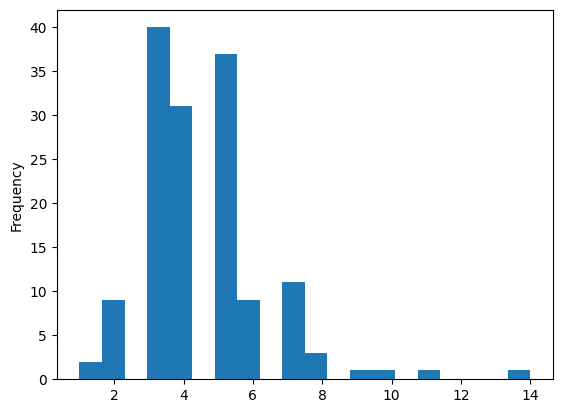

In [2]:
df["ground_truth"].apply(len).plot.hist(bins=20)

## 2. RAG system

In [3]:
from gatherer_sage.rag import RAG
from datasets import Dataset

rag = RAG(vector_database_path="../data/rag_vector_db", reranker_model_path=None)

df["contexts"] = df["question"].apply(rag.retrieve_relevant_docs)
df["contexts"]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. 

497     [Name: Library of Leng\nMana Cost: 1 colorless...
1262    [Rules:\n1. Although Lich’s Mirror has you dra...
411     [Name: Naga Vitalist\nMana Cost: 1 colorless, ...
1047    [Name: Magus of the Moon\nMana Cost: 2 colorle...
1034    [Name: Gift of Doom\nMana Cost: 4 colorless, b...
                              ...                        
1078    [5. In a four-player game, if you have a level...
101     [Name: Bitter Ordeal\nMana Cost: 2 colorless, ...
881     [Name: Grudge Keeper\nMana Cost: 1 colorless, ...
1167    [Name: Astral Slide\nMana Cost: 2 colorless, w...
1023    [Name: Khalni Hydra\nMana Cost: green, green, ...
Name: contexts, Length: 146, dtype: object

In [15]:
rag_eval_dataset = Dataset.from_pandas(
    df[["contexts", "answer", "ground_truth", "question"]]
)

## 3. Ragas Evaluation

In [21]:
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_precision,
    context_recall,
)
from ragas import evaluate
from datasets import Dataset

test_dataset = Dataset.from_dict(
    {
        "question": ["When was the first super bowl?", "Who won the most super bowls?"],
        "answer": [
            "The first superbowl was held on Jan 15, 1967",
            "The most super bowls have been won by The New England Patriots",
        ],
        "contexts": [
            [
                "The First AFL-NFL World Championship Game was an American football game played on January 15, 1967, at the Los Angeles Memorial Coliseum in Los Angeles,"
            ],
            [
                "The Green Bay Packers...Green Bay, Wisconsin.",
                "The Packers compete...Football Conference",
            ],
        ],
        "ground_truth": [
            "The first superbowl was held on January 15, 1967",
            "The New England Patriots have won the Super Bowl a record six times",
        ],
    }
)

# Run on terminal: python -m vllm.entrypoints.openai.api_server --model explodinggradients/Ragas-critic-llm-Qwen1.5-GPTQ
inference_server_url = "http://localhost:8000/v1"
MODEL = "explodinggradients/Ragas-critic-llm-Qwen1.5-GPTQ"
chat = ChatOpenAI(
    model=MODEL,
    openai_api_key="token-abc123",
    openai_api_base=inference_server_url,
    max_tokens=2048,
    temperature=0,
)
print(evaluate(test_dataset, metrics=[context_recall, context_precision], llm=chat))

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]
/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/ragas/evaluation.py:299: RuntimeWarning: Mean of empty slice
  value = np.nanmean(self.scores[cn])


{'context_recall': nan, 'context_precision': 0.0000}


In [16]:
print(evaluate(rag_eval_dataset, metrics=[context_recall, context_precision], llm=chat))

Evaluating:   0%|          | 0/292 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Evaluating:   0%|          | 1/292 [00:04<24:13,  5.00s/it]Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse outpu

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.